In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Аналитика портфолио/data_raw.csv')


In [4]:
# Преобразуем данные в формат сводной таблицы
df_pivot = data.pivot_table(
    index=['client_id', 'dt'],
    columns='event_type',
    aggfunc='size',
    fill_value=0
).reset_index()

# Преобразуем в бинарный формат: если есть событие — 1, иначе 0
df_pivot[['views', 'clicks', 'adds']] = (df_pivot[['views', 'clicks', 'adds']] > 0).astype(int)

# Сортируем сначала по client_id, затем по dt
df_pivot = df_pivot.sort_values(by=['client_id', 'dt']).reset_index(drop=True)

# Выводим результат
print(df_pivot.head())

# Сохраняем обработанные данные
df_pivot.to_csv("/content/drive/MyDrive/Аналитика портфолио/processed_data.csv", index=False)


event_type  client_id          dt  adds  clicks  views
0                   1  2024-06-17     0       0      1
1                   1  2024-06-19     0       0      1
2                   3  2024-06-17     0       1      1
3                   3  2024-06-18     0       1      1
4                   3  2024-06-19     1       1      1


views     8267094
clicks     370039
adds       148700
dtype: int64


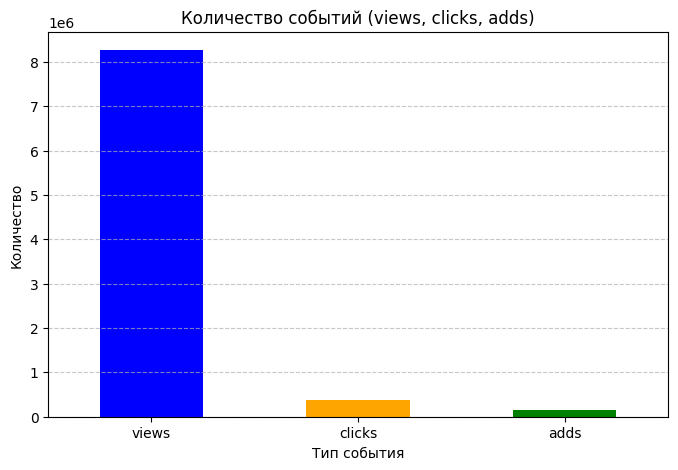

CTR (конверсия в просмотр): 4.48%
CR (конверсия в добавление): 40.18%


In [5]:

# Загружаем обработанный файл
df = pd.read_csv("/content/drive/MyDrive/Аналитика портфолио/processed_data.csv")


# 1. Выводим количество по каждому событию
event_counts = df[["views", "clicks", "adds"]].sum()
print(event_counts)

# 2. Строим график количества событий
plt.figure(figsize=(8, 5))
event_counts.plot(kind="bar", color=["blue", "orange", "green"])
plt.title("Количество событий (views, clicks, adds)")
plt.xlabel("Тип события")
plt.ylabel("Количество")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 3. Считаем ключевые метрики (CTR и CR)
ctr = df["clicks"].sum() / df["views"].sum()
cr = df["adds"].sum() / df["clicks"].sum()

print(f"CTR (конверсия в просмотр): {ctr:.2%}")
print(f"CR (конверсия в добавление): {cr:.2%}")







In [13]:
import numpy as np
from scipy.stats import norm

# Данные из анализа
views = 8267094
clicks = 370039
adds = 148700

# Конверсии
ctr = clicks / views  # Конверсия в просмотр (CTR)
cr = adds / clicks  # Конверсия в добавление (CR)

# Дисперсии
var_ctr = ctr * (1 - ctr)
var_cr = cr * (1 - cr)

# Размер выборки
n = views  # Общее количество просмотров

# Z-значения для 95% доверия и 80% мощности
z_alpha = norm.ppf(1 - 0.05 / 2)  # 1.96
z_beta = norm.ppf(1 - 0.2)  # 0.84

# Расчет MDE
mde_ctr = np.sqrt(2 * var_ctr / n) * (z_alpha + z_beta)
mde_cr = np.sqrt(2 * var_cr / n) * (z_alpha + z_beta)

# Вывод результатов (в процентах)

print(f"MDE_CTR : {mde_ctr:.2%}")
print(f"MDE_CR: {mde_cr:.2%}")


MDE_CTR : 0.03%
MDE_CR: 0.07%


In [16]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Заданные параметры
alpha = 0.05  # Уровень значимости
beta = 0.2    # Мощность теста 1 - beta = 80%

# Z-значения
Z_alpha = norm.ppf(1 - alpha / 2)
Z_beta = norm.ppf(1 - beta)

# Исходные данные
CTR_mean = 4.48/100   # Средний CTR (0.02%)
CR_mean = 40.18/100   # Средний CR (0.23%)

# Приблизительное стандартное отклонение (по биномиальной формуле)
CTR_std = np.sqrt(CTR_mean * (1 - CTR_mean))
CR_std = np.sqrt(CR_mean * (1 - CR_mean))

# Размеры выборок
sample_sizes = np.arange(10000, 210000, 10000)

# Расчет MDE
mde_results = []
for n in sample_sizes:
    MDE_CTR = (Z_alpha + Z_beta) * CTR_std / np.sqrt(n)
    MDE_CR = (Z_alpha + Z_beta) * CR_std / np.sqrt(n)
    mde_results.append([n, MDE_CTR, MDE_CR])

# Создаем DataFrame
df_mde = pd.DataFrame(mde_results, columns=['Выборка', 'MDE_CTR', 'MDE_CR'])

# Выводим таблицу
print(df_mde)


    Выборка   MDE_CTR    MDE_CR
0     10000  0.005795  0.013735
1     20000  0.004098  0.009712
2     30000  0.003346  0.007930
3     40000  0.002898  0.006868
4     50000  0.002592  0.006143
5     60000  0.002366  0.005607
6     70000  0.002190  0.005191
7     80000  0.002049  0.004856
8     90000  0.001932  0.004578
9    100000  0.001833  0.004343
10   110000  0.001747  0.004141
11   120000  0.001673  0.003965
12   130000  0.001607  0.003809
13   140000  0.001549  0.003671
14   150000  0.001496  0.003546
15   160000  0.001449  0.003434
16   170000  0.001406  0.003331
17   180000  0.001366  0.003237
18   190000  0.001330  0.003151
19   200000  0.001296  0.003071


In [19]:
import pandas as pd
import scipy.stats as stats

def analyze_ab_test(file_path):
    # Загружаем данные
    res = pd.read_csv(file_path)

    # Группируем по экспериментальной группе
    summary = res.groupby("ab_group").agg(
        total_users=("client_id", "nunique"),
        total_views=("is_view_ads", "sum"),
        total_clicks=("cnt_view_ads", "sum"),
        total_adds=("cnt_adds_ads", "sum"),
        total_orders=("cnt_orders_ads", "sum"),
        total_revenue=("sum_orders_ads", "sum")
    ).reset_index()

    # Рассчитываем метрики
    summary["CTR"] = summary["total_clicks"] / summary["total_views"]
    summary["CR_Adds"] = summary["total_adds"] / summary["total_clicks"]
    summary["CR_Orders"] = summary["total_orders"] / summary["total_clicks"]
    summary["ARPU"] = summary["total_revenue"] / summary["total_users"]
    summary["ARPPU"] = summary["total_revenue"] / summary["total_orders"]

    # Разделяем тестовую и контрольную группу
    control = res[res["ab_group"] == "control"]
    test = res[res["ab_group"] == "test"]

    # Статистические тесты
    ctr_p_value = stats.ttest_ind(test["cnt_view_ads"], control["cnt_view_ads"], equal_var=False).pvalue
    cr_p_value = stats.ttest_ind(test["cnt_adds_ads"], control["cnt_adds_ads"], equal_var=False).pvalue
    revenue_p_value = stats.ttest_ind(test["sum_orders_ads"], control["sum_orders_ads"], equal_var=False).pvalue

    significance_results = {
        "CTR p-value": ctr_p_value,
        "CR_Adds p-value": cr_p_value,
        "Revenue p-value": revenue_p_value,
        "CTR Significant": ctr_p_value < 0.05,
        "CR_Adds Significant": cr_p_value < 0.05,
        "Revenue Significant": revenue_p_value < 0.05
    }

    return summary, significance_results

# Запуск анализа
file_path = "/content/drive/MyDrive/Аналитика портфолио/final_results_to_analyze.csv"
summary, significance_results = analyze_ab_test(file_path)

# Вывод результатов
print("Метрики по группам:")
print(summary)
print("\nРезультаты статистического теста:")
print(significance_results)

Метрики по группам:
  ab_group  total_users  total_views  total_clicks  total_adds  total_orders  \
0  control       200786        25389         43469       15799          5579   
1     test       200474        25852         43805       16337          5881   

   total_revenue       CTR   CR_Adds  CR_Orders      ARPU       ARPPU  
0        1589899  1.712119  0.363454   0.128344  7.918376  284.979208  
1        1687895  1.694453  0.372948   0.134254  8.419521  287.008162  

Результаты статистического теста:
{'CTR p-value': 0.7079439461730692, 'CR_Adds p-value': 0.16736601313485483, 'Revenue p-value': 0.042774140139963536, 'CTR Significant': False, 'CR_Adds Significant': False, 'Revenue Significant': True}


In [18]:
import pandas as pd

def analyze_experiment_results(file_path):
    # Загружаем данные
    final_res = pd.read_csv(file_path)

    # Основные метрики
    total_users = final_res['client_id'].nunique()
    total_views = final_res['cnt_view_ads'].sum()
    total_clicks = final_res['is_view_ads'].sum()
    total_adds = final_res['cnt_adds_ads'].sum()
    total_orders = final_res['cnt_orders_ads'].sum()
    total_revenue = final_res['sum_orders_ads'].sum()

    # Метрики по конверсиям
    ctr = total_clicks / total_views if total_views > 0 else 0  # Кликабельность секции рекламы
    cr_adds = total_adds / total_clicks if total_clicks > 0 else 0  # Конверсия в добавление товаров
    cr_adds_from_views = total_adds / total_views if total_views > 0 else 0  # Конверсия в добавление от просмотра
    cr_orders = total_orders / total_clicks if total_clicks > 0 else 0  # Конверсия в заказ от захода в рекламу
    cr_orders_from_views = total_orders / total_views if total_views > 0 else 0  # Конверсия в заказ от просмотра

    # Выручка
    arpu = total_revenue / total_users if total_users > 0 else 0  # Выручка на пользователя
    arppu = total_revenue / total_orders if total_orders > 0 else 0  # Выручка на покупателя

    # Дополнительные метрики
    avg_order_value = total_revenue / total_orders if total_orders > 0 else 0  # Средний чек
    avg_orders_per_user = total_orders / total_users if total_users > 0 else 0  # Среднее количество заказов на пользователя

    results = {
        'Total Users': total_users,
        'Total Views': total_views,
        'Total Clicks': total_clicks,
        'Total Adds': total_adds,
        'Total Orders': total_orders,
        'Total Revenue': total_revenue,
        'CTR': ctr,
        'CR Adds': cr_adds,
        'CR Adds from Views': cr_adds_from_views,
        'CR Orders': cr_orders,
        'CR Orders from Views': cr_orders_from_views,
        'ARPU': arpu,
        'ARPPU': arppu,
        'Average Order Value': avg_order_value,
        'Avg Orders per User': avg_orders_per_user
    }

    return results

# Пример вызова функции
file_path = '/content/drive/MyDrive/Аналитика портфолио/final_results_to_analyze.csv'
results = analyze_experiment_results(file_path)
print(results)

{'Total Users': 394867, 'Total Views': 87274, 'Total Clicks': 51241, 'Total Adds': 32136, 'Total Orders': 11460, 'Total Revenue': 3277794, 'CTR': 0.5871278960515159, 'CR Adds': 0.6271540368064635, 'CR Adds from Views': 0.36821963013039394, 'CR Orders': 0.22364903104935502, 'CR Orders from Views': 0.13131058505396798, 'ARPU': 8.301007681067295, 'ARPPU': 286.02041884816754, 'Average Order Value': 286.02041884816754, 'Avg Orders per User': 0.029022430337303447}


In [21]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Загружаем данные
analyz = pd.read_csv("/content/drive/MyDrive/Аналитика портфолио/final_results_to_analyze.csv")

# Группируем данные по экспериментальным группам
grouped = analyz.groupby("ab_group").agg(
    total_users=("client_id", "nunique"),
    total_views=("is_view_ads", "sum"),
    total_clicks=("cnt_view_ads", "sum"),
    total_adds=("cnt_adds_ads", "sum"),
    total_orders=("cnt_orders_ads", "sum"),
    total_revenue=("sum_orders_ads", "sum"),
    avg_order_value=("sum_orders_ads", "mean"),
    avg_orders_per_user=("cnt_orders_ads", "mean"),
    avg_cart_value=("sum_adds_ads", "mean"),
    avg_adds_per_user=("cnt_adds_ads", "mean"),
).reset_index()

# Вычисляем дополнительные метрики
grouped["CTR"] = grouped["total_clicks"] / grouped["total_views"]
grouped["CR_Adds"] = grouped["total_adds"] / grouped["total_clicks"]
grouped["CR_Orders"] = grouped["total_orders"] / grouped["total_clicks"]
grouped["ARPU"] = grouped["total_revenue"] / grouped["total_users"]
grouped["ARPPU"] = grouped["total_revenue"] / grouped["total_orders"]

print("Метрики по группам:\n", grouped)

# Разделяем данные по группам
control_group = analyz[analyz["ab_group"] == "control"]
test_group = analyz[analyz["ab_group"] == "test"]

# Статистические тесты
metrics = ["cnt_view_ads", "cnt_adds_ads", "cnt_orders_ads", "sum_orders_ads"]
p_values = {}

for metric in metrics:
    stat, p_val = ttest_ind(control_group[metric], test_group[metric], equal_var=False, nan_policy="omit")
    p_values[f"{metric} p-value"] = p_val

# Вывод значимости различий
significance = {key: (p_val < 0.05) for key, p_val in p_values.items()}

print("\nРезультаты статистического теста:")
print(p_values)
print("Значимые различия:", significance)


Метрики по группам:
   ab_group  total_users  total_views  total_clicks  total_adds  total_orders  \
0  control       200786        25389         43469       15799          5579   
1     test       200474        25852         43805       16337          5881   

   total_revenue  avg_order_value  avg_orders_per_user  avg_cart_value  \
0        1589899         3.245632             0.011389        5.026804   
1        1687895         3.433109             0.011962        5.138580   

   avg_adds_per_user       CTR   CR_Adds  CR_Orders      ARPU       ARPPU  
0           0.032252  1.712119  0.363454   0.128344  7.918376  284.979208  
1           0.033229  1.694453  0.372948   0.134254  8.419521  287.008162  

Результаты статистического теста:
{'cnt_view_ads p-value': 0.7079439461730692, 'cnt_adds_ads p-value': 0.16736601313485483, 'cnt_orders_ads p-value': 0.04059213036963724, 'sum_orders_ads p-value': 0.042774140139963536}
Значимые различия: {'cnt_view_ads p-value': False, 'cnt_adds_ads p-